# Convolutional Neural Networks Part 2:

 - Methods To Handle Overfitting

### Sources:

 - https://keras.io/applications/
 - https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d
 - https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
 - https://neurohive.io/en/popular-networks/vgg16/
 - https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
 - https://github.com/Xinyi6/CIFAR10-CNN-by-Keras/blob/master/doc/CIFAR10%20CNN%20use%20Keras.pdf
 - https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

#### Turn Off Messages:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Fix: UnknownError: Failed to get convolution algorithm. 
# This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, load_model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [4]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

def accuracyFunc(labelsActual, labelsPred):
    accuracy = (np.sum(labelsActual == labelsPred) / len(labelsActual)) * 100
    return accuracy

# Plot Features of CIFAR-10 data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[ 6320 41093 17208 ... 18548  5302 36789] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 1st 10 Images From Randomized Data:

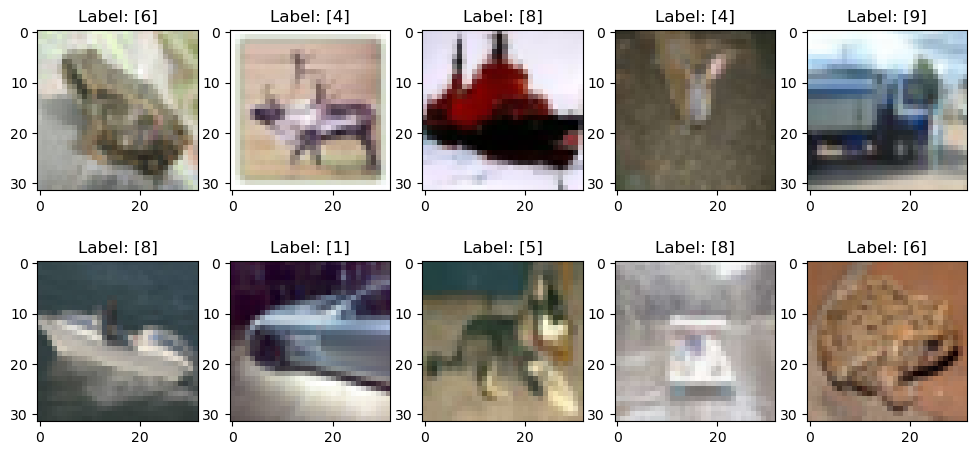

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

### 1st Method: Image-Data Augmentation Only:

#### Define The Model:

In [10]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
model4.add(Activation('relu'))
model4.add(Conv2D(32, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model4.add(Dense(units=512, activation='relu'))
model4.add(Dropout(0.5)) # Helps to reduce overfitting
model4.add(Dense(units=len(classes), activation='softmax'))
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

#### Compile The Model:

 - Create A Data Generator For Real-Time Data Augmentation

In [11]:
opt4 = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy', optimizer=opt4, metrics=['accuracy'])

datagen4 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#### Compute Quantities Required For Featurewise Normalization:

 - std deviation, mean & principal components if ZCA Whitening is Applied.

In [12]:
datagen4.fit(x_train)

#### Create A Checkpoint To Save Best Model:

 - Based On Lowest Validation Loss

In [13]:
save_path4 = '../assets/Lecture7/model4_ckpt.h5'
callbacks_save4 = ModelCheckpoint(save_path4, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

#### Fit The Model Using The Data Generator & Plot Statistics:

Two Methods To Flow The Images:


1. `.flow_from_directory()` Data Generator For Large Datasets:

`image_generator = image.datagen.flow_from_directory('data/images', class_mode=None, seed=seed)`


2. `.flow()` for small datasets loaded into memory:

`model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(train) / 32, epochs=epochs`

Epoch 1/50
2500/2500 [==============================] - 30s 10ms/step - loss: 1.8296 - accuracy: 0.3153 - val_loss: 1.2529 - val_accuracy: 0.5504
Epoch 2/50
2500/2500 [==============================] - 22s 9ms/step - loss: 1.2852 - accuracy: 0.5395 - val_loss: 1.0331 - val_accuracy: 0.6260
Epoch 3/50
2500/2500 [==============================] - 21s 9ms/step - loss: 1.1217 - accuracy: 0.6004 - val_loss: 0.9606 - val_accuracy: 0.6594
Epoch 4/50
2500/2500 [==============================] - 21s 8ms/step - loss: 1.0352 - accuracy: 0.6349 - val_loss: 0.9407 - val_accuracy: 0.6699
Epoch 5/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9706 - accuracy: 0.6548 - val_loss: 0.8464 - val_accuracy: 0.7015
Epoch 6/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9175 - accuracy: 0.6778 - val_loss: 0.7965 - val_accuracy: 0.7209
Epoch 7/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9072 - accuracy: 0.6826 - val_loss: 0.8120 - val_a

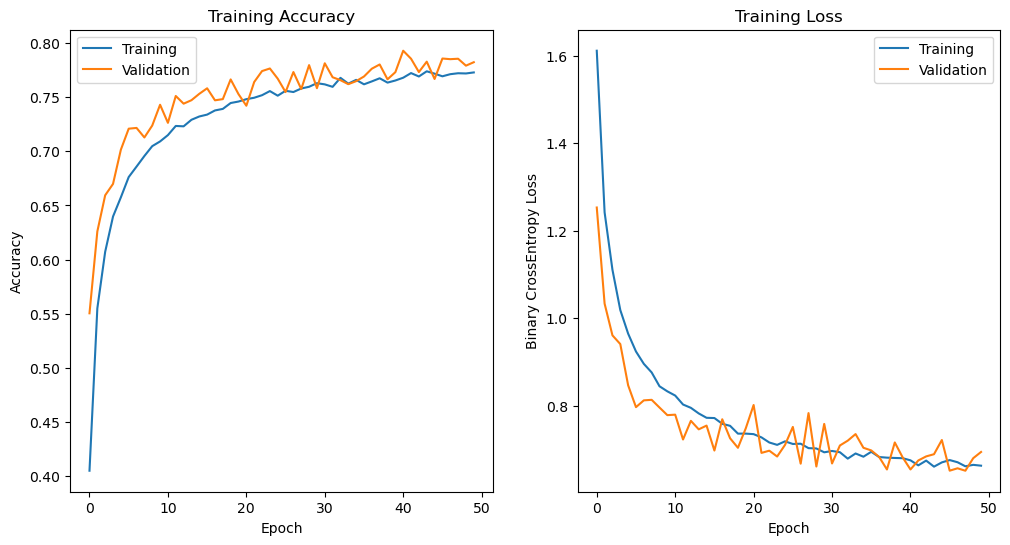


Training Accuracy: 77.285 %
Training Loss: 0.6627


Validation Accuracy: 78.23 %
Validation Loss: 0.6941



In [14]:
history4 = model4.fit(datagen4.flow(x_train, y_train_c, batch_size=16), 
                      steps_per_epoch=len(x_train) / 16, epochs=50, 
                      verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save4])

plotEverything(history4)

#### Load Best Model & Evaluate:

In [15]:
model4a = load_model(save_path4)

score4a = model4a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score4a[0]}')
print(f'Accuracy From Training Set: {score4a[1]}\n')

score4b = model4a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score4b[0]}')
print(f'Accuracy From Validation Set: {score4b[1]}\n')

score4c = model4a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score4c[0]}')
print(f'Accuracy From Testing Set: {score4c[1]}\n')

1250/1250 [==============================] - 3s 2ms/step - loss: 0.4798 - accuracy: 0.8357
Total Loss From Training Set: 0.47982051968574524
Accuracy From Training Set: 0.8356500267982483

313/313 [==============================] - 1s 4ms/step - loss: 0.6512 - accuracy: 0.7855
Total Loss From Validation Set: 0.6511979699134827
Accuracy From Validation Set: 0.7854999899864197

313/313 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.7856
Total Loss From Testing Set: 0.6677590012550354
Accuracy From Testing Set: 0.7856000065803528



#### Predict Class Of Held Out Samples:

In [16]:
test_class1_prob = model4.predict(x_test)
test_labels = np.argmax(test_class1_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels, y_test) * 100} %\n')
conf_matrix = confusion_matrix(test_labels, y_test)

colLabels = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix = pd.DataFrame(conf_matrix, columns=colLabels, index=rowLabels,)
display(fancyMatrix)

The Accuracy Predicting The Test Set is: 77.7 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,850,2,81,39,32,19,13,22,92,11
Actual Car,31,925,10,23,3,10,15,8,49,58
Actual Bird,24,1,673,58,47,37,26,28,10,5
Actual Cat,8,1,27,512,36,106,25,24,2,4
Actual Deer,5,0,47,50,738,31,21,24,1,0
Actual Dog,3,0,40,128,13,672,13,37,1,0
Actual Frog,6,2,69,93,68,50,864,5,0,1
Actual Horse,3,0,23,35,57,40,5,824,4,2
Actual Ship,21,3,15,10,2,7,9,3,799,6
Actual Truck,49,66,15,52,4,28,9,25,42,913


### 2nd Method: Batch Normalization Without Data Augmentation:

 - Adds a 'normalization layer' after each convolutional layer.
     - Between Convolutional Layer and Activation Layer.
     - No need for bias in the Convolutional Layer.
 - Model Converges Much Faster In Training
     - Can Use higher Learning Rates.

#### Define The Model:

In [17]:
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model5.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model5.add(Dense(units=512))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5)) # Helps to reduce overfitting
model5.add(Dense(units=len(classes)))
model5.add(BatchNormalization())
model5.add(Activation('softmax'))
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)       

#### Compile The Model:

 - Increase Learning Rate 10x: 0.001 to 0.01
 - Increase Batch Size 4x: 16 to 64

Epoch 1/50
625/625 [==============================] - 20s 20ms/step - loss: 1.5269 - accuracy: 0.4534 - val_loss: 1.5492 - val_accuracy: 0.4706
Epoch 2/50
625/625 [==============================] - 10s 15ms/step - loss: 0.9145 - accuracy: 0.6807 - val_loss: 1.1770 - val_accuracy: 0.6016
Epoch 3/50
625/625 [==============================] - 10s 15ms/step - loss: 0.7418 - accuracy: 0.7417 - val_loss: 1.1663 - val_accuracy: 0.5953
Epoch 4/50
625/625 [==============================] - 10s 15ms/step - loss: 0.6181 - accuracy: 0.7841 - val_loss: 0.7649 - val_accuracy: 0.7376
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5156 - accuracy: 0.8217 - val_loss: 0.6951 - val_accuracy: 0.7725
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 0.4324 - accuracy: 0.8491 - val_loss: 0.7272 - val_accuracy: 0.7662
Epoch 7/50
625/625 [==============================] - 9s 15ms/step - loss: 0.3587 - accuracy: 0.8747 - val_loss: 0.7388 - val_accuracy: 0.

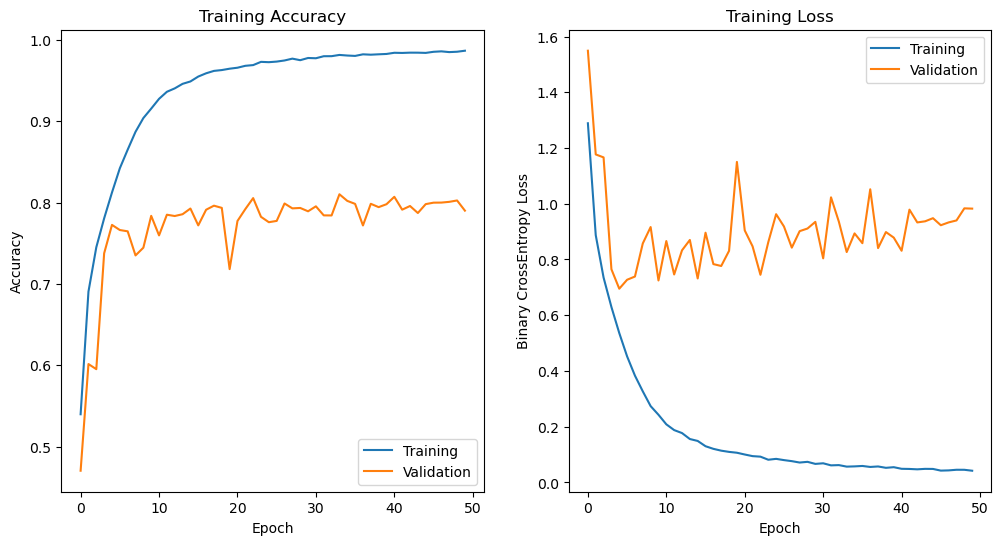


Training Accuracy: 98.64 %
Training Loss: 0.0419


Validation Accuracy: 79.0 %
Validation Loss: 0.9825



In [18]:
save_path5 = '../assets/Lecture7/model5_ckpt.h5'
callbacks_save5 = ModelCheckpoint(save_path5, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt5 = tf.keras.optimizers.Adam(learning_rate=0.01)
model5.compile(loss='categorical_crossentropy', optimizer=opt5, metrics=['accuracy'])

history5 = model5.fit(x_train, y_train_c, batch_size=64, 
                      epochs=50, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save5])

plotEverything(history5)

#### Load Best Model & Evaluate:

In [19]:
model5a = load_model(save_path5)

score5a = model5a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score5a[0]}')
print(f'Accuracy From Training Set: {score5a[1]}\n')

score5b = model5a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score5b[0]}')
print(f'Accuracy From Validation Set: {score5b[1]}\n')

score5c = model5a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score5c[0]}')
print(f'Accuracy From Testing Set: {score5c[1]}\n')

1250/1250 [==============================] - 7s 3ms/step - loss: 0.3659 - accuracy: 0.8790
Total Loss From Training Set: 0.36590367555618286
Accuracy From Training Set: 0.8790000081062317

313/313 [==============================] - 1s 4ms/step - loss: 0.6951 - accuracy: 0.7725
Total Loss From Validation Set: 0.6951197385787964
Accuracy From Validation Set: 0.7724999785423279

313/313 [==============================] - 2s 5ms/step - loss: 0.6951 - accuracy: 0.7680
Total Loss From Testing Set: 0.6951457262039185
Accuracy From Testing Set: 0.7680000066757202



#### Predict Class Of Held Out Samples:

In [20]:
test_class2_prob = model5.predict(x_test)
test_labels2 = np.argmax(test_class2_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels2, y_test) * 100} %\n')
conf_matrix2 = confusion_matrix(test_labels2, y_test)

colLabels2 = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels2 = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix2 = pd.DataFrame(conf_matrix2, columns=colLabels2, index=rowLabels2,)
display(fancyMatrix2)

The Accuracy Predicting The Test Set is: 77.89 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,785,8,35,11,1,3,2,12,61,24
Actual Car,14,917,2,6,1,4,1,1,26,66
Actual Bird,65,7,691,63,63,41,37,19,21,4
Actual Cat,28,10,79,682,107,146,71,60,36,29
Actual Deer,22,1,51,31,700,26,13,49,5,4
Actual Dog,15,6,65,143,39,763,22,66,10,15
Actual Frog,19,13,58,45,62,7,848,10,19,8
Actual Horse,2,3,11,15,23,8,4,775,7,8
Actual Ship,18,4,4,1,4,2,1,0,792,6
Actual Truck,32,31,4,3,0,0,1,8,23,836


### 3rd Method: Batch Normalization With Data Augmentation:

#### Define The Model With Normalization Layers:

In [21]:
model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model6.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model6.add(Dense(units=512))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.5)) # Helps to reduce overfitting
model6.add(Dense(units=len(classes)))
model6.add(BatchNormalization())
model6.add(Activation('softmax'))
model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_47 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)       

#### Compile The Model:

 - Still Using Same Parameters As Model 2
 - Increase Learning Rate 10x: 0.001 to 0.01
 - Increase Batch Size 4x: 16 to 64
 - Create A Data Generator For Real-Time Data Augmentation

In [22]:
save_path6 = '../assets/Lecture7/model3_ckpt.h5'
callbacks_save6 = ModelCheckpoint(save_path6, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt6 = tf.keras.optimizers.Adam(learning_rate=0.01)
model6.compile(loss='categorical_crossentropy', optimizer=opt6, metrics=['accuracy'])

datagen6 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#### Compute Quantities Required For Featurewise Normalization:

 - std deviation, mean & principal components if ZCA Whitening is Applied.

In [23]:
datagen6.fit(x_train)

#### Fit The Model Using Data Generator & Batch Normalization:

Epoch 1/50
625/625 [==============================] - 29s 35ms/step - loss: 1.5365 - accuracy: 0.4503 - val_loss: 1.2200 - val_accuracy: 0.5802
Epoch 2/50
625/625 [==============================] - 20s 32ms/step - loss: 0.8977 - accuracy: 0.6874 - val_loss: 1.3076 - val_accuracy: 0.5592
Epoch 3/50
625/625 [==============================] - 20s 33ms/step - loss: 0.7221 - accuracy: 0.7485 - val_loss: 1.3233 - val_accuracy: 0.5861
Epoch 4/50
625/625 [==============================] - 21s 34ms/step - loss: 0.6042 - accuracy: 0.7899 - val_loss: 0.8388 - val_accuracy: 0.7094
Epoch 5/50
625/625 [==============================] - 21s 34ms/step - loss: 0.5119 - accuracy: 0.8224 - val_loss: 0.7358 - val_accuracy: 0.7446
Epoch 6/50
625/625 [==============================] - 22s 36ms/step - loss: 0.4304 - accuracy: 0.8530 - val_loss: 0.7539 - val_accuracy: 0.7498
Epoch 7/50
625/625 [==============================] - 23s 36ms/step - loss: 0.3672 - accuracy: 0.8719 - val_loss: 0.8689 - val_accuracy:

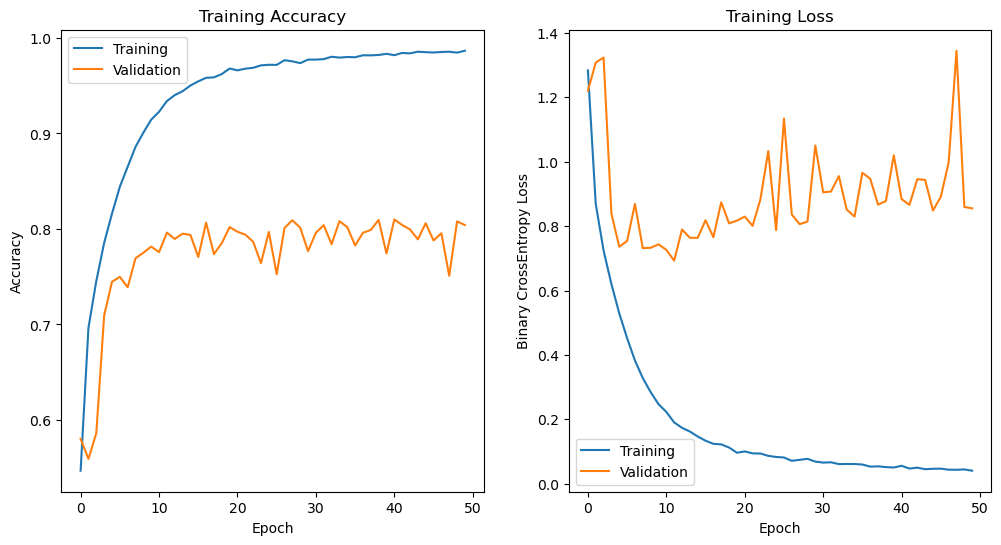


Training Accuracy: 98.655 %
Training Loss: 0.0406


Validation Accuracy: 80.4 %
Validation Loss: 0.8551



In [24]:
history6 = model6.fit(x_train, y_train_c, batch_size=64, 
                      epochs=50, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save6])

plotEverything(history6)                      

#### Load Best Model & Evaluate:

In [26]:
model6a = load_model(save_path6)

score6a = model6a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score6a[0]}')
print(f'Accuracy From Training Set: {score6a[1]}\n')

score6b = model6a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score6b[0]}')
print(f'Accuracy From Validation Set: {score6b[1]}\n')

score6c = model6a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score6c[0]}')
print(f'Accuracy From Testing Set: {score6c[1]}\n')

1250/1250 [==============================] - 8s 6ms/step - loss: 0.0788 - accuracy: 0.9787
Total Loss From Training Set: 0.07879770547151566
Accuracy From Training Set: 0.9786750078201294

313/313 [==============================] - 4s 11ms/step - loss: 0.6927 - accuracy: 0.7961
Total Loss From Validation Set: 0.6926698684692383
Accuracy From Validation Set: 0.7961000204086304

313/313 [==============================] - 3s 10ms/step - loss: 0.7087 - accuracy: 0.7886
Total Loss From Testing Set: 0.7086798548698425
Accuracy From Testing Set: 0.7886000275611877



#### Predict Class Of Held Out Samples:

In [28]:
test_class3_prob = model6.predict(x_test)
test_labels3 = np.argmax(test_class3_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels3, y_test) * 100} %\n')
conf_matrix3 = confusion_matrix(test_labels3, y_test)

colLabels3 = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels3 = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix3 = pd.DataFrame(conf_matrix3, columns=colLabels3, index=rowLabels3,)
display(fancyMatrix3)

The Accuracy Predicting The Test Set is: 80.15 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,823,8,52,15,9,6,6,7,64,27
Actual Car,16,906,5,6,2,3,0,2,13,55
Actual Bird,36,3,621,33,20,23,18,11,6,2
Actual Cat,17,5,47,598,29,105,22,13,10,8
Actual Deer,18,2,89,66,809,42,16,38,5,6
Actual Dog,6,3,61,141,26,741,10,36,3,4
Actual Frog,19,13,92,97,51,36,917,16,12,13
Actual Horse,7,0,22,27,43,34,7,868,6,6
Actual Ship,31,13,8,9,9,5,4,3,868,15
Actual Truck,27,47,3,8,2,5,0,6,13,864


#### L1 L2 Regularization:

 - https://keras.io/api/layers/regularizers/

In [ ]:
layers = layers.Dense(
    units=64, kernel_regularizer=regularizers.l1_l2(l1 = 1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

#### Data Generator In Keras:
 
 - For small datasets loaded into memory
 - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)